In [1]:
import os
import sys
code_root = os.path.dirname(os.path.dirname(os.getcwd()))
if code_root not in sys.path:
    sys.path.append(code_root)
print(code_root)

/Users/matthewmcpartlon/VSCode/AttnPacker


In [2]:
import torch
from typing import Optional, Union
from torch import Tensor

import protein_learning.models.model_abc.train as sc
from protein_learning.models.utils.model_io import (
    load_n_save_args,
    print_args,
    get_args_n_groups,
    load_args_for_eval,
)
from protein_learning.models.fbb_design.train import Train as SCPTrain, _augment
from protein_learning.common.data.datasets.utils import set_canonical_coords_n_masks
from protein_learning.common.data.data_types.protein import Protein
import protein_learning.common.protein_constants as pc
from protein_learning.features.input_embedding import InputEmbedding
from protein_learning.models.utils.dataset_augment_fns import impute_cb
from protein_learning.common.data.data_types.model_input import ModelInput



def exists(x):
    return x is not None


def default(x, y):
    return x if exists(x) else y


def _parse_args(arg_stream):
    args = []
    for x in arg_stream:  # noqa
        line = x.strip()
        if len(line.strip()) > 0 and not line.startswith("#"):
            arg = line.split(" ")
            for a in arg:
                args.append(a)
    return args


def parse_args(arg_path=None, arg_list=None, arg_string=None):
    if exists(arg_list):
        return arg_list
    elif exists(arg_path):
        with open(arg_path, "r") as f:
            return _parse_args(f)
    elif exists(arg_string):
        return _parse_args(arg_string.split("\n"))
    else:
        raise Exception("All inputs are None!")
        
def make_predicted_protein(model_out, seq: Optional[Union[str,Tensor]] = None) -> Protein:
    """Constructs predicted protein"""
    if torch.is_tensor(seq):
        seq = "".join([pc.INDEX_TO_AA_ONE[x.item()] for x in seq.squeeze()])
    coords = model_out.predicted_coords.squeeze(0)
    pred_protein = model_out.decoy_protein.from_coords_n_seq(coords,seq)
    pred_protein = set_canonical_coords_n_masks(pred_protein, overwrite=True)
    return pred_protein
        
        
INFERENCE_ARGS = """
# whether todesign sequence
--mask_seq
# Don't mask any residues in input sequence
--no_mask_weight 1
--inter_no_mask_weight 1
#--no_predict_from_angles
"""


class Inference:
    def __init__(
        self, 
        model_n_config_root: str,
        use_design_model: bool = True,
        verbose=True,
    ):
        if use_design_model:
            model_name = 'fbb_design_21_12_2022_16:07:51'
        else:
            model_name = 'fbb_design_ft2_21_12_2022_15:57:43'#'fbb_design_21_12_2022_15:58:28'
        self.model_name = model_name
        self.use_design_model = use_design_model
        self.verbose = verbose
        self.trainer = SCPTrain()
        self.resource_root = model_n_config_root
        self.load_inference_args()
        self.trainer.pad_embeddings = self.args.mask_seq or self.args.mask_feats
        self.trainer._setup()

    def load_inference_args(self): 
        eval_parser = sc.get_default_parser_for_eval()
        self.trainer.add_extra_cmd_line_options_for_eval(eval_parser)
        # default inference args
        arg_list = parse_args(arg_string=INFERENCE_ARGS)
        eval_args, eval_groups = get_args_n_groups(eval_parser, arg_list)
        self.trainer.eval_args = eval_args
        self.trainer.eval_groups = eval_groups

        train_parser = self.trainer.add_extra_cmd_line_options(sc.get_default_parser())
        train_args, train_groups = get_args_n_groups(train_parser, ["none"])  # defaults only

        global_override = sc.default_global_override_for_eval(eval_args)
        global_override.update(self.trainer.global_override_eval)  # args that should always be overridden
        rr = self.resource_root
        config, args, arg_groups = load_args_for_eval(
            global_config_path=os.path.join(rr,"params",f"{self.model_name}.npy"),
            model_config_path=os.path.join(rr,"params",f"{self.model_name}_fbb_design.npy"),
            model_override=self.trainer.model_override_eval,
            global_override=global_override,
            default_model_args=train_args,
            default_model_arg_groups=train_groups,
        )

        if self.verbose:
            print(f"global override\n {global_override}")
            print(f"model override\n {self.trainer.model_override_eval}")
        self.config, self.args, self.arg_groups = config, args, arg_groups
        self.trainer.config = config
        self.trainer.args=args
        self.trainer.arg_groups=arg_groups
        
        return config, args, arg_groups
    
    def _init_model(self):
        # set up feature generator
        feature_config = sc.get_input_feature_config(
            self.arg_groups,
            pad_embeddings=self.trainer.pad_embeddings,
            extra_pair_feat_dim=self.trainer.extra_pair_feat_dim,
            extra_res_feat_dim=self.trainer.extra_res_feat_dim,
        )
        self.feature_config = feature_config  # noqa
        feat_gen = sc.get_feature_gen(
            self.arg_groups, feature_config, apply_masks=self.trainer.apply_masks
        )
        self.feat_gen = feat_gen  # noqa
        self.input_embedding = InputEmbedding(feature_config)
        self.model = self.trainer.get_model(self.input_embedding)
    
    def get_model(self):
        self._init_model()
        model_path = os.path.join(self.resource_root,"models",f"{self.model_name}.tar")
        checkpoint = torch.load(model_path, map_location="cpu")
        self.model.load_state_dict(checkpoint['model'],strict=True)
        return self.model
    
    def load_example(
        self,
        pdb_path,
        fasta_path = None,
        seq_mask = None
    ):
        if exists(seq_mask):
            assert self.use_design_model
            
        protein = Protein.FromPDBAndSeq(
            pdb_path = pdb_path,
            seq=fasta_path,
            atom_tys = pc.ALL_ATOMS,
            missing_seq = fasta_path is None,
            load_ss=False,
        )
        protein, _ = impute_cb(protein,protein)
        extra = _augment(protein, protein)
        protein = set_canonical_coords_n_masks(protein)
        
        return ModelInput(
            decoy=protein,
            native=protein,
            input_features=self.feat_gen.generate_features(
                protein,
                extra=extra,
                seq_mask=seq_mask,
            ),
            extra=extra,
        )

        
        


/Users/matthewmcpartlon/miniconda3/envs/py38/lib/python3.8/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(


In [3]:
RESOURCE_ROOT = "/Users/matthewmcpartlon/Downloads/AttnPackerPTM"
runner = Inference(RESOURCE_ROOT, verbose=False, use_design_model=True)
model = runner.get_model()
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = model.to(device).eval()

[WARNING] : no value for key help, arg_group : optional arguments
[INFO] adding embeddings for res_ty: [1]
[INFO] adding embeddings for rel_pos: [1]
[INFO] adding embeddings for bb_dihedral: [1]
[INFO] adding embeddings for centrality: [0]
[INFO] adding embeddings for rel_sep: []
[INFO] adding embeddings for rel_dist: [0]
[INFO] adding embeddings for tr_ori: [1]
[INFO] adding embeddings for rel_chain: [1]
------------------------------------------------------
[INFO] Input feature embeddings

----[INFO] SCALAR (dim = 115)

--------res_ty
------------one_hot : 23
--------rel_pos
------------one_hot : 11
--------bb_dihedral
------------one_hot : 75
--------centrality
------------rbf : 6

----[INFO] PAIR (dim = 205)

--------rel_sep
--------rel_dist
------------rbf : 64
--------tr_ori
------------one_hot : 75
--------rel_chain
------------one_hot : 6
--------joint_pair_n_sep
------------rel_sep : 60
------------res_ty_a : 60
------------res_ty_b : 60

--------------------------------------

# Run Inference

In [4]:
import time
pdb_path = "./pdbs/T1043.pdb"
design_mask = None
mask_frac = 0
if runner.use_design_model:
    design_mask = None #torch.rand(79)>(1-mask_frac) #mask out 50% of residue identities at random
example = runner.load_example(pdb_path = pdb_path, seq_mask = design_mask)

In [5]:
start = time.time()
with torch.no_grad():
    model_out = model.forward(example.to(device), use_cycles = 1)
    print(f"Ran inference in {round(time.time() - start,3)} seconds")

/Users/matthewmcpartlon/miniconda3/envs/py38/lib/python3.8/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Ran inference in 3.354 seconds


## Gather Model Output

In [6]:
#masked residue positions
seq_mask = default(
    example.input_features.seq_mask,torch.zeros(len(example.decoy)).bool()
)

# coords, pLDDT, and Sequence
res_feats = model_out.scalar_output
pred_coords = model_out.predicted_coords
pred_seq_labels = model_out.decoy_protein.seq_encoding
pred_seq_logits = None


# Predicted pLDDT
plddt_head = model.loss_fn.loss_fns["plddt"]
pred_plddt = plddt_head.get_expected_value(res_feats)
pred_plddt = pred_plddt

# Predicted Sequence
if "nsr" in model.loss_fn and torch.any(seq_mask):
    pred_seq_logits = model.loss_fn.loss_fns["nsr"].get_predicted_logits(res_feats)
    pred_seq_labels = torch.argmax(pred_seq_logits,dim=-1)

out = pred_coords, pred_seq_labels, pred_seq_logits, pred_plddt
fn = lambda x : x.detach().cpu().squeeze() if torch.is_tensor(x) else x
pred_coords, pred_seq_labels, pred_seq_logits, pred_plddt = map(fn,out)


## Write prediction to pdb

In [7]:
pred_protein = make_predicted_protein(model_out, seq = pred_seq_labels)
pdb_out_path = f"./attn_packer/examples/{pred_protein.name}_packed.pdb"
print(f"saving pdb to {pdb_out_path}")
pred_protein.to_pdb(pdb_out_path)

saving pdb to ./attn_packer/examples/T1043_packed.pdb


## Apply Post-Processing Procedure to Prediction

In [8]:
from protein_learning.protein_utils.sidechains.project_sidechains import project_onto_rotamers

pp_pdb_out_path = f"./attn_packer/examples/{pred_protein.name}_packed_pp.pdb"

projected_coords, _ = project_onto_rotamers(
    atom_coords = pred_protein.atom_coords.unsqueeze(0),
    sequence = pred_protein.seq_encoding.unsqueeze(0),
    atom_mask = pred_protein.atom_masks.unsqueeze(0),
    steric_clash_weight=[0.5],
    steric_loss_kwargs = dict(
            global_tol_frac=0.9,
            hbond_allowance=0.6,
            global_allowance=0.05, 
            reduction = "sum",
            p=2
        ),
)

pred_protein.to_pdb(pp_pdb_out_path, coords=projected_coords.squeeze())


[fn: project_onto_rotamers] : Using device cpu
[INFO] Beginning rotamer projection
[INFO] Initial loss values
   [RMSD loss] = 3.155
   [Steric loss] = 159.236
   [Angle Dev. loss] = 0.0

beginning iter: 0, steric weight: 0.5
beginning iter: 1, steric weight: 0.5
[INFO] Final Loss Values
   [RMSD loss] = 3.141
   [Steric loss] = 111.734
   [Angle Dev. loss] = 0.001



## Check out packing with NGL Viewer

### Before Post-Process

In [20]:
!jupyter-nbextension enable nglview --py --sys-prefix

Enabling notebook extension nglview-js-widgets/extension...
      - Validating: OK


In [22]:
import nglview as nv
view = nv.show_file(pdb_out_path)
view.add_cartoon("protein",color_scheme='residue_index')
view.add_ball_and_stick("protein")
view

NGLWidget()

### After Post-Process

In [23]:
import nglview as nv
view = nv.show_file(pp_pdb_out_path)
view.add_cartoon("protein",color_scheme='residue_index')
view.add_ball_and_stick("protein")
view

NGLWidget()

## Examine Predicted pLDDT

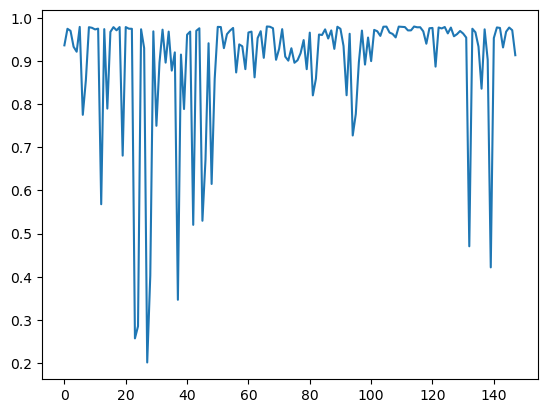

In [11]:
import matplotlib.pyplot as plt
plt.plot(torch.arange(pred_plddt.numel()),pred_plddt.squeeze())

## Examine Predicted Sequences (If Doing Sequence Design)

In [12]:
pred_protein = make_predicted_protein(model_out, seq = pred_seq_labels)
x,y = model_out.decoy_protein.seq, pred_protein.seq

print("Input Sequence :\n",x)
print("Predicted Sequence :\n",y)
aln="".join(["|" if x[i]!=y[i] else " " for i in range(len(x))])
masked="".join(["*" if seq_mask[i] else " " for i in range(len(x))])
print("Aligned:")
print(f" {x}\n {aln}\n {y}\n {masked}")

Input Sequence :
 SFEEQFIKNNSDSNILAPKVSQSVIKSIKGIKSKHVFELPINDKTKRYILGATETKEEVLPNYVKVGSDLYRLKAYREKSGVYVRTNKLGFEDPKSFLSIKEYKFGTRTGGNFTGELTKQELVYTNQWVNENITLANGYISADSRTVD
Predicted Sequence :
 SFEEQFIKNNSDSNILAPKVSQSVIKSIKGIKSKHVFELPINDKTKRYILGATETKEEVLPNYVKVGSDLYRLKAYREKSGVYVRTNKLGFEDPKSFLSIKEYKFGTRTGGNFTGELTKQELVYTNQWVNENITLANGYISADSRTVD
Aligned:
 SFEEQFIKNNSDSNILAPKVSQSVIKSIKGIKSKHVFELPINDKTKRYILGATETKEEVLPNYVKVGSDLYRLKAYREKSGVYVRTNKLGFEDPKSFLSIKEYKFGTRTGGNFTGELTKQELVYTNQWVNENITLANGYISADSRTVD
                                                                                                                                                     
 SFEEQFIKNNSDSNILAPKVSQSVIKSIKGIKSKHVFELPINDKTKRYILGATETKEEVLPNYVKVGSDLYRLKAYREKSGVYVRTNKLGFEDPKSFLSIKEYKFGTRTGGNFTGELTKQELVYTNQWVNENITLANGYISADSRTVD
                                                                                                                                                     


In [13]:
model_out.__dict__

{'predicted_coords': tensor([[[[155.041, 115.764,  45.020],
           [154.305, 115.681,  46.274],
           [155.177, 115.292,  47.461],
           ...,
           [154.305, 115.681,  46.274],
           [154.305, 115.681,  46.274],
           [154.305, 115.681,  46.274]],
 
          [[156.477, 115.063,  47.259],
           [157.324, 114.640,  48.371],
           [157.591, 115.788,  49.336],
           ...,
           [157.324, 114.640,  48.371],
           [157.324, 114.640,  48.371],
           [157.324, 114.640,  48.371]],
 
          [[157.967, 116.954,  48.799],
           [158.486, 118.067,  49.588],
           [157.692, 118.313,  50.867],
           ...,
           [158.486, 118.067,  49.588],
           [158.486, 118.067,  49.588],
           [158.486, 118.067,  49.588]],
 
          ...,
 
          [[157.172, 134.072,  44.495],
           [158.283, 133.141,  44.354],
           [159.574, 133.937,  44.242],
           ...,
           [158.283, 133.141,  44.354],
          

In [14]:
# ^^ angles are being predicted

In [15]:
[k for k in model.__dict__]

['training',
 '_parameters',
 '_buffers',
 '_non_persistent_buffers_set',
 '_backward_hooks',
 '_is_full_backward_hook',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_state_dict_hooks',
 '_load_state_dict_pre_hooks',
 '_load_state_dict_post_hooks',
 '_modules',
 'node_in',
 'pair_in',
 'project_in',
 'device_indices',
 'secondary_device',
 'main_device',
 'n_dist_bins_for_recycle',
 'n_cycles',
 'use_cycles',
 'torsion_loss_weight',
 'use_tfn',
 'node_dim_in',
 'pair_dim_in',
 'predict_from_angles',
 'to_points',
 'pre_structure_pair',
 'pre_structure_node']

In [16]:
model.predict_from_angles

False

In [17]:
for name, par in model.named_parameters():
    print(name)

model.attn_layers.0.attn_block.attn.self_bias
model.attn_layers.0.attn_block.attn.null_bias
model.attn_layers.0.attn_block.attn.to_self_kv.0.weight
model.attn_layers.0.attn_block.attn.to_self_kv.1.weight
model.attn_layers.0.attn_block.attn.null_keys.0
model.attn_layers.0.attn_block.attn.null_keys.1
model.attn_layers.0.attn_block.attn.null_values.0
model.attn_layers.0.attn_block.attn.null_values.1
model.attn_layers.0.attn_block.attn.to_bias.weight
model.attn_layers.0.attn_block.attn.to_out.projs.0.weight
model.attn_layers.0.attn_block.attn.to_out.projs.1.weight
model.attn_layers.0.attn_block.attn.to_kv.kernel_unary.(0,0).rp.net.0.weight
model.attn_layers.0.attn_block.attn.to_kv.kernel_unary.(0,0).rp.net.0.bias
model.attn_layers.0.attn_block.attn.to_kv.kernel_unary.(0,0).rp.net.1.weight
model.attn_layers.0.attn_block.attn.to_kv.kernel_unary.(0,0).rp.net.1.bias
model.attn_layers.0.attn_block.attn.to_kv.kernel_unary.(0,0).rp.net.4.weight
model.attn_layers.0.attn_block.attn.to_kv.kernel_una

In [18]:
runner.args.predict_from_angles

False

In [19]:

model_path = os.path.join(runner.resource_root,"models",f"{runner.model_name}.tar")
checkpoint = torch.load(model_path, map_location="cpu")

for i,k in enumerate(checkpoint["model"]):
    print(k)


model.attn_layers.0.attn_block.attn.self_bias
model.attn_layers.0.attn_block.attn.null_bias
model.attn_layers.0.attn_block.attn.to_self_kv.0.weight
model.attn_layers.0.attn_block.attn.to_self_kv.1.weight
model.attn_layers.0.attn_block.attn.null_keys.0
model.attn_layers.0.attn_block.attn.null_keys.1
model.attn_layers.0.attn_block.attn.null_values.0
model.attn_layers.0.attn_block.attn.null_values.1
model.attn_layers.0.attn_block.attn.to_bias.weight
model.attn_layers.0.attn_block.attn.to_out.projs.0.weight
model.attn_layers.0.attn_block.attn.to_out.projs.1.weight
model.attn_layers.0.attn_block.attn.to_kv.kernel_unary.(0,0).rp.net.0.weight
model.attn_layers.0.attn_block.attn.to_kv.kernel_unary.(0,0).rp.net.0.bias
model.attn_layers.0.attn_block.attn.to_kv.kernel_unary.(0,0).rp.net.1.weight
model.attn_layers.0.attn_block.attn.to_kv.kernel_unary.(0,0).rp.net.1.bias
model.attn_layers.0.attn_block.attn.to_kv.kernel_unary.(0,0).rp.net.4.weight
model.attn_layers.0.attn_block.attn.to_kv.kernel_una